In [1]:
#### IF you are using Google colab only then please do the following to make it easy to work in colab. 
# Uncomment and run cells in colab
#-----------------------------------------------------------------------------------------------

# 1. Mount ur google drive where the course folder is downloaded.
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# 2. Set the path to the course directory
# import os
# os.chdir('/content/drive/My Drive/Course-1-Deep-Learning-Mastery-Build-Your-AI-Foundation-main/Section5-DL-ComputerVision-P1')
# print("Current Directory:", os.getcwd())

In [3]:
# 3. install the following libraries. u can install any other library also with !pip install "library"
# !pip install tensorflow numpy pandas matplotlib

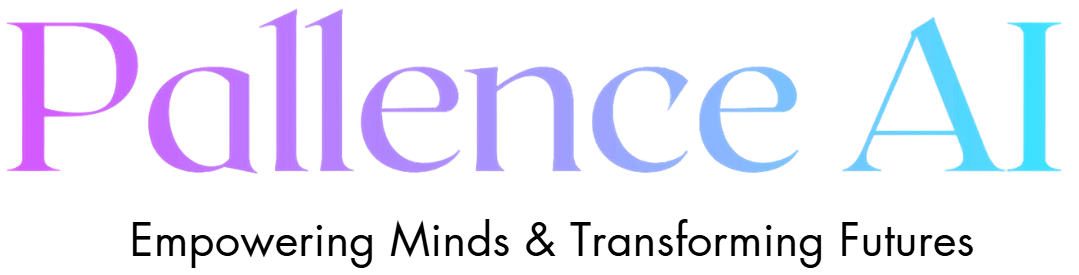

In [1]:
from IPython.display import Image, display
display(Image("./images/PallenceAI-Final.png", width=800))

# Transfer Learning: Leveraging Pretrained Models

### Transfer Learning can be done in many different ways depending on the task at hand

1.  Extract the features from pretrained models and use that as a starting point for our training 


2.  Fine tune the pretrained model 
    * By freezing the convbase of the model
    * **By freezing some layers and unfreezing some layers**
    * By fine-tuning all the layers.

## Fine tune on Select Layers of VGG16 Architecture below.

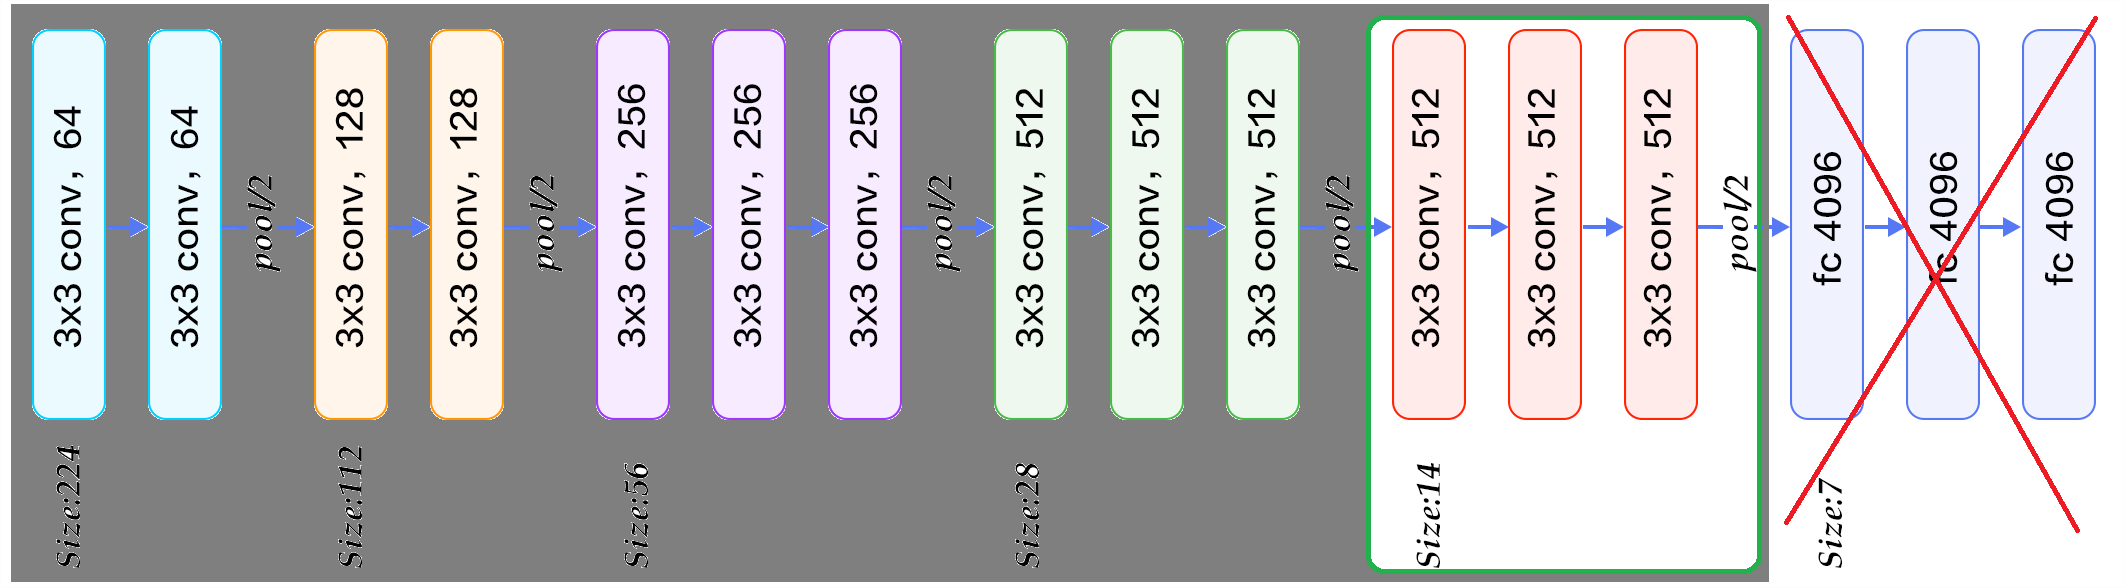

In [2]:
display(Image("./images/vgg16-3.png", width=800))

**Import needed libraries**

In [1]:
#Basic Python packages for data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

#Tensorflow & Keras related packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers

from utils import plot_history

### Load Cifar Dataset Preloaded in Keras

In [2]:
from tensorflow.keras.datasets import cifar10

In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [4]:
# Use the last 10,000 images from training to create a validation dataset
val_images = train_images[40000:]
val_labels = train_labels[40000:]

# And use the first 40,000 images for training
train_images = train_images[:40000]
train_labels = train_labels[:40000]

### Preprocess the image by
1. Resizing the image and use preprocessing which the vgg16 model expectss
2. convert our data (train_images, train_labels) into tf.data object

In [5]:
# This function preprocess the images as per the requirements of vgg16 pretrained model

def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize the image
    image = keras.applications.vgg16.preprocess_input(image)
    
    #image = image / 255.0  # We were scaling our images like this before
    return image, label

In [6]:
# This function converts training data into a Tensorflow data objects, 
#...preprocesses and organizes data into batches 
# Ensures data is loaded efficiently through prefetching. 

def make_dataset(images, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)) #tf.data object for efficient data loading & preprocessing
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [7]:
# Preparocess all the datasets
train_dataset = make_dataset(train_images, train_labels, batch_size=32)
test_dataset = make_dataset(test_images, test_labels, batch_size=32)
val_dataset = make_dataset(val_images, val_labels, batch_size=32)

In [8]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

### Load  VGG16 Architecture trained on ImageNet dataset: 1.4 million images with 1000 different classes

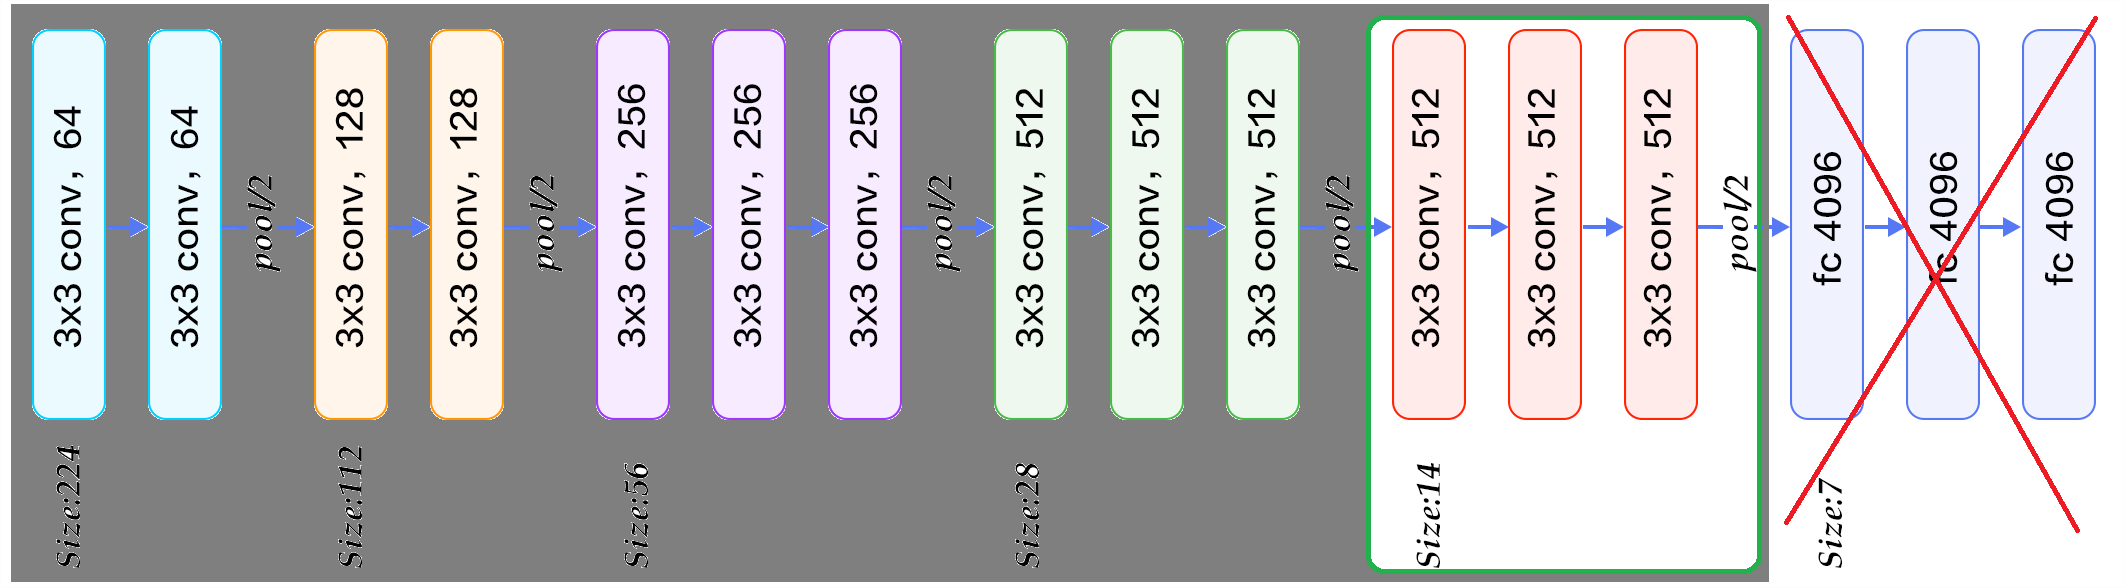

In [3]:
display(Image("./images/vgg16-3.png", width=800))

In [9]:
#Load the Convolution base of the architecture. We will ignore the last three layers
convbase_model = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3))

In [10]:
convbase_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

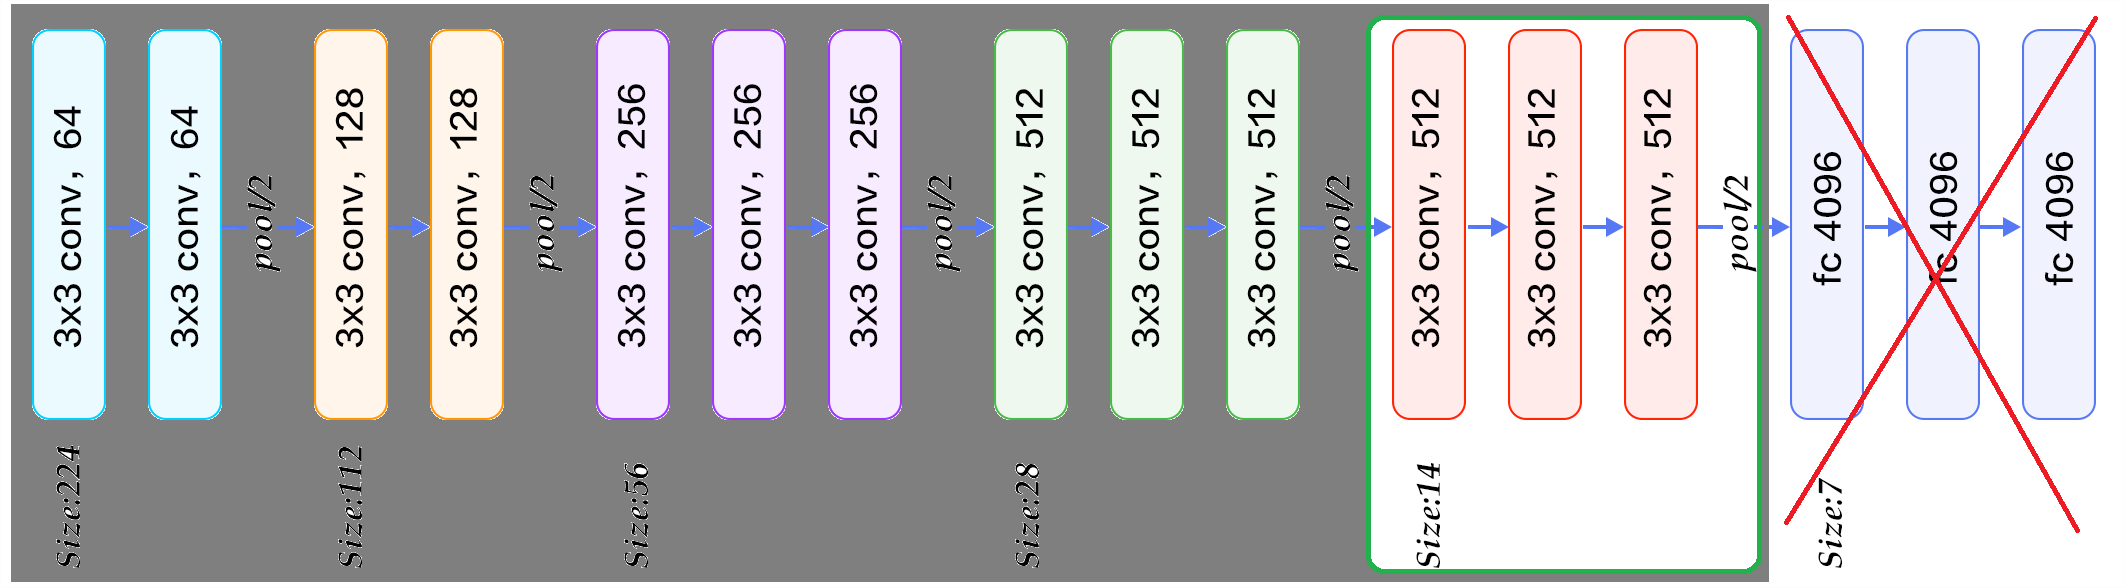

In [4]:
display(Image("./images/vgg16-3.png", width=800))

### Define the model architecture including VGG16 Convolution Base

In [11]:
from tensorflow.keras import backend as K
K.clear_session()

In [12]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
# Here we are not extracting features from the convbase and then passing it as input as we did before

# Instead 
# ..We will integrate vgg16 convbase architecture into ours.
# ..Fine tune only those layers that we want to

def cifar_vgg16_selectlayers(base_model): 
      
    # choose which layers we want to freeze. We will freeze all layers except the last 4
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    
    # Define Input shape
    inputs = keras.Input(shape = (224,224,3)) 
    
    # get Vgg16 base model output by passing in input 
    x = base_model(inputs) 

    # Flatten
    x = layers.Flatten()(x) 
  
    # Dense layer with 256 units
    x = layers.Dense(256, activation="relu")(x) 
    x = layers.Dropout(0.4)(x) # Dropout layer
    
    # Final dense output layer with 10 units
    outputs = layers.Dense(10, activation="softmax")(x) 
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Fine Tune Select Layers

In [14]:
# Instantiate the model by freezing weights of base model
model = cifar_vgg16_selectlayers(convbase_model) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 21,140,042
Trainable params: 13,504,778
Non-tra

### Compile & Train

In [15]:
# Compile the Model by configuring the  optimizer, loss function & metrics 

sgd = tf.keras.optimizers.SGD(lr=0.001) # sgd optimizer

model.compile(optimizer=sgd,loss='sparse_categorical_crossentropy',  metrics = ["accuracy"]) 

C:\Users\sridh\anaconda3\envs\tf2.10_env\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
## CallBacks

# call back for reducing learning rate as the training proceeds
def lr_scheduler(epoch):
    return 0.001 * (0.5 ** (epoch // 20))
schedule_lr = keras.callbacks.LearningRateScheduler(lr_scheduler) 

early_stop = keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                           patience=3, 
                                           restore_best_weights=True)

callbacks = [schedule_lr, early_stop] 

In [17]:
# Train the model
history = model.fit(train_dataset, epochs = 30, batch_size = 32, 
                    validation_data=val_dataset,callbacks=callbacks) 

Epoch 1/30
1250/1250 [==============================] - 225s 171ms/step - loss: 0.9599 - accuracy: 0.6826 - val_loss: 0.5377 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 2/30
1250/1250 [==============================] - 237s 189ms/step - loss: 0.4654 - accuracy: 0.8432 - val_loss: 0.4033 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 3/30
1250/1250 [==============================] - 211s 168ms/step - loss: 0.3076 - accuracy: 0.8953 - val_loss: 0.3542 - val_accuracy: 0.8836 - lr: 0.0010
Epoch 4/30
1250/1250 [==============================] - 207s 166ms/step - loss: 0.2133 - accuracy: 0.9267 - val_loss: 0.3381 - val_accuracy: 0.8898 - lr: 0.0010
Epoch 5/30
1250/1250 [==============================] - 201s 160ms/step - loss: 0.1493 - accuracy: 0.9488 - val_loss: 0.3499 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 6/30
1250/1250 [==============================] - 202s 162ms/step - loss: 0.1033 - accuracy: 0.9660 - val_loss: 0.3522 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 7/30
1250/1250 [============

In [ ]:
plot_history(history)

In [ ]:
model.evaluate(test_dataset, batch_size=32) 